In [ ]:
# 1. Imports and Configurations
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [ ]:
#2. Load Data
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (444, 2)
Test shape: (204, 1)


,filename,label
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


In [ ]:
# 3. Feature Extraction from Audio
def extract_features(file_path, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    features = {}

    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)[0]
    features['rmse'] = np.mean(librosa.feature.rms(y=y).T, axis=0)[0]
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)[0]
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)[0]
    features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, axis=0)[0]
    features['mfcc_mean'] = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

    for i, val in enumerate(features['mfcc_mean']):
        features[f'mfcc_{i+1}'] = val
    del features['mfcc_mean']

    return features

train_features = []
for fname in train_df['filename']:
    path = os.path.join("audio", "train", fname)
    feats = extract_features(path)
    train_features.append(feats)

X = pd.DataFrame(train_features)
y = train_df['label']

test_features = []
for fname in test_df['filename']:
    path = os.path.join("audio", "test", fname)
    feats = extract_features(path)
    test_features.append(feats)

X_test = pd.DataFrame(test_features)

In [9]:
# 4. Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
# 5. Model Training - XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=SEED)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

val_pearson = pearsonr(y_val, val_preds)[0]

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Validation Pearson Correlation:", val_pearson)

Training RMSE: 0.04955952813347457
Validation RMSE: 0.9176034318445058
Validation Pearson Correlation: 0.6769044134495888


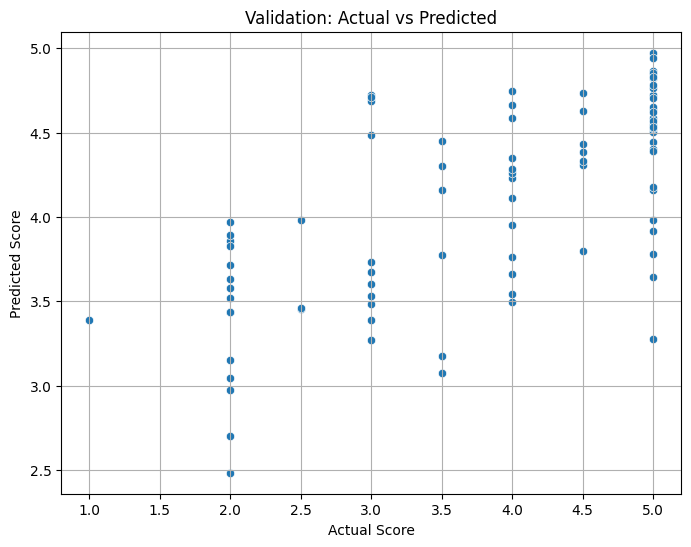

In [ ]:
# 6. Visualizations
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=val_preds)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Validation: Actual vs Predicted")
plt.grid(True)
plt.show()

In [ ]:
# 7. Final Predictions and Submission
test_preds = model.predict(X_test)
sample_submission['score'] = test_preds
sample_submission.to_csv("submission.csv", index=False)

In [18]:
# 8. Brief Report
report = f"""
# Report

# Problem Statement:
Predict the grammar score (0 to 5) of spoken audio samples using machine learning.

# Preprocessing Steps:
- Used Librosa to extract meaningful audio features:
  - Zero-Crossing Rate
  - Root Mean Square Energy
  - Spectral Centroid, Bandwidth, Rolloff
  - 13 MFCC coefficients
- Standard sampling rate set to 16kHz.
- Audio files stored inside 'audio/train/' and 'audio/test/' folders.

# Pipeline Architecture:
1. Extract features from `.wav` files
2. Train/validation split (80/20)
3. XGBoost Regressor trained on extracted features

# Evaluation Results:
- **Training RMSE**: {train_rmse:.4f}
- **Validation RMSE**: {val_rmse:.4f}
- **Validation Pearson Correlation**: {val_pearson:.4f}

# Observations:
- Basic handcrafted features give reasonable performance
- Improvement expected with deep audio embeddings or fine-tuning audio-specific models (e.g., Wav2Vec2)

"""

print(report)


# Report

# Problem Statement:
Predict the grammar score (0 to 5) of spoken audio samples using machine learning.

# Preprocessing Steps:
- Used Librosa to extract meaningful audio features:
  - Zero-Crossing Rate
  - Root Mean Square Energy
  - Spectral Centroid, Bandwidth, Rolloff
  - 13 MFCC coefficients
- Standard sampling rate set to 16kHz.
- Audio files stored inside 'audio/train/' and 'audio/test/' folders.

# Pipeline Architecture:
1. Extract features from `.wav` files
2. Train/validation split (80/20)
3. XGBoost Regressor trained on extracted features

# Evaluation Results:
- **Training RMSE**: 0.0496
- **Validation RMSE**: 0.9176
- **Validation Pearson Correlation**: 0.6769

# Observations:
- Basic handcrafted features give reasonable performance
- Improvement expected with deep audio embeddings or fine-tuning audio-specific models (e.g., Wav2Vec2)


